In [3]:
import torch.nn as nn
import torch
import pandas as pd
from gensim import models
import numpy as np
import matplotlib.pyplot as plt

In [4]:
augmented_data = pd.read_csv('./drive/My Drive/augmented_data.csv')

In [ ]:
augmented_data

In [5]:
w = models.KeyedVectors.load_word2vec_format(
    './drive/My Drive/GoogleNews-vectors-negative300 (1).bin', binary=True)

In [6]:
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]  

In [7]:
def clean_sentence(sentence):
  cleaned_sentence = ''
  for char in sentence:
    if char.isalpha() or char == ' ':
      cleaned_sentence += char
    if char == '-':
      cleaned_sentence += ' '
  return cleaned_sentence

In [8]:
def vectorize_sentence(sentence,vectorizer,max_len):
  cleaned_sentence = clean_sentence(sentence)
  sentence_lst = cleaned_sentence.split()
  num_words = len(sentence_lst)
  sentence_vector = np.zeros((max_len,300))
  for i in range(num_words):
    word = sentence_lst[i]
    if word not in stopwords:
      vectorized_word = vectorizer.wv[word]
    else:
      vectorized_word = np.zeros(300)
    sentence_vector[i] = vectorized_word
  for j in range(num_words,max_len,1):
    sentence_vector[j] = np.zeros(300)
  return sentence_vector

In [9]:
def vectorize_dataset(df):
  num_rows = len(df.index)
  text_commands = df['Text Command']
  max_len = max([len(text_commands.loc[i].split()) for i in range(num_rows)])
  data_vector = np.zeros((num_rows,max_len,300))
  shuffled_df = df.sample(frac=1).reset_index(drop=True)
  for i in df.index.values:
    sentence = shuffled_df.loc[i][0]
    vectorized_sentence = vectorize_sentence(sentence,w,max_len) 
    data_vector[i] = vectorized_sentence
  return data_vector, shuffled_df['One Hot Encoded Topic'], max_len

In [10]:
vectorized_dataset, labels, max_len = vectorize_dataset(augmented_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


In [11]:
for i in (labels.index.values):
  labels.loc[i] = np.fromstring(labels.loc[i][1:-1], dtype=np.float64, sep=',')

In [12]:
labels = torch.tensor(labels)

In [30]:
text_commands = torch.tensor(vectorized_dataset)

In [31]:
text_commands = text_commands[:1100]
labels = labels[:1100]

In [15]:
#LSTM architecture that takes input of vectorized sentences and outputs probability for each topic
class TopicModeler(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    
    super(TopicModeler,self).__init__()
    self.hidden_size = hidden_size
    self.LSTM = nn.LSTM(input_size,hidden_size,batch_first = True)
    self.output2topic = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self,input):
    output, (h_n,c_n) = self.LSTM(input)
    topic_output = self.output2topic(output)
    prob_output = self.softmax(topic_output)
    return prob_output



In [32]:
#set feature size of hidden units
hidden_size = 100

#feature dimension of Google Word2Vec word vector(default is 300)
input_size = 300

#number of topics to predict
num_topics = 3

#initialize LSTM
model = TopicModeler(input_size, hidden_size, num_topics)

#set learning rate 
lr = .01

#set training loss metric
loss_metric = nn.NLLLoss()

#set batch size 
batch_size = 50

#set number of batches
num_batches = int(len(text_commands)/batch_size)

#reshape text commands and labels to fit training
text_commands = torch.reshape(text_commands,(num_batches,batch_size,max_len,300))
labels = torch.reshape(labels,(num_batches,batch_size,num_topics))

In [17]:
text_commands.shape

torch.Size([22, 50, 9, 300])

In [22]:
def train(topic_tensor, text_command_tensor):
    model.zero_grad()

    output = model(text_command_tensor.float())

    loss = torch.mean(loss_metric(output, topic_tensor.long()),dim=-1)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-lr)

    return output, loss.item()

In [33]:
epochs = 150
print_every = 100
plot_every = 1



# Keep track of losses for plotting
current_loss = 0
all_losses = []

for iter in range(1, epochs + 1):
  for batch_iter in range(num_batches):
    text_batch, label_batch = text_commands[batch_iter], labels[batch_iter]
    output, loss = train(label_batch, text_batch)
    current_loss += loss

    # Print iter number, loss, name and guess
    #if iter % print_every == 0:
        #guess, guess_i = categoryFromOutput(output)
        #correct = '✓' if guess == category else '✗ (%s)' % category
        #print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
  all_losses.append(current_loss / num_batches)
  current_loss = 0

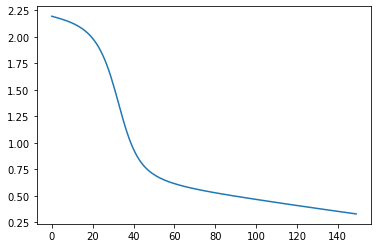

In [34]:
plt.figure()
plt.plot(all_losses)